# Simulations of CT data

In [2]:
import numpy as np
import torch
import pandas as pd
import sys, os
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import estimators

Definition of variables :

- N : total number of patients of the CT
- m : number of patients in treated arm
- n : number of patients in control arm (such that $N = n + m$)
- Y : outcome (continuous)
- T : treatment variable (0/1)
- X : baseline variables used as predictors
- Z : covariates or potential confounders (when needed in further experiments)
- f : prediction function under hypothesis $T=0$ ($f:X \mapsto f(X)$)
- $\sigma_c$ : standard deviation for control arm
- $\sigma_t$ : standard deviation for treated arm
- $\sigma_f$ : standard deviation for $f(X)$
- $\sigma_\delta$ : standard deviation of $f(X) - Y_{T=0}$
- $\rho_t$ : covariance between $Y_{T=1}$ and $f(X)$
- $\rho_c$ : correlation between $Y_{T=0}$ and $f(X)$

# I - Simulations with ADSim

## I.1) Power computing

In [106]:
path_exp = '/Users/p-e.poulet/Documents/Aramis/code/notebooks/PPI_CT/simulated_data/Exp1_paper/'
files = os.listdir(path_exp)
files = [file for file in files if file[:4]=='data']
len(files)

4000

In [107]:
estimations = []
variances = []

np.random.seed(42)

step = 0.4
for file in files:
    [_, N, k] = file[:-4].split('_')
    data = pd.read_csv(os.path.join(path_exp, file))
    data["Treatment"] = (data["Treatment"]=='Treatment').astype(int)
    data["Model"] = 70. / (1. + np.exp(-data["Eta"] - data["Week"] * data["Alpha"]))
    data.set_index(['Week', 'SubjId'], inplace=True)
    data.sort_index(inplace=True)
    for i in range(25):
        noise = int(i)*step  
        data["Predictions"] = data["Model"] + np.random.normal(0., noise, size=data.shape[0])
        # Select end of trial
        df = data.loc[52].copy()
        df["Adas_change"] = df["Adas"] - data.loc[0]["Adas"]
        df["Predictions_change"] = df["Predictions"] - data.loc[0]["Adas"]
        est, var = estimators.compute_estimators(df, endpoint="Adas_change", treatment="Treatment", prognostic="Predictions_change", covariates=["BMMSE"])
        est["Noise_level"] = noise
        est["R2"] = np.corrcoef(df["Adas_change"], df["Predictions_change"])[0,1]
        est["Repeat_number"] = int(k)
        estimations.append(est)
        var["Noise_level"] = noise
        var["Repeat_number"] = int(k)
        variances.append(var)
estimations = pd.concat(estimations, axis=0)
variances = pd.concat(variances, axis=0)

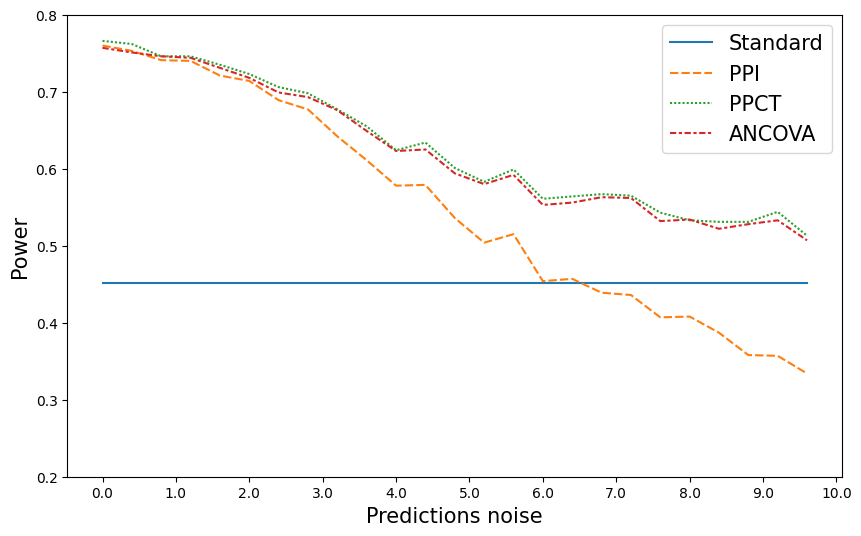

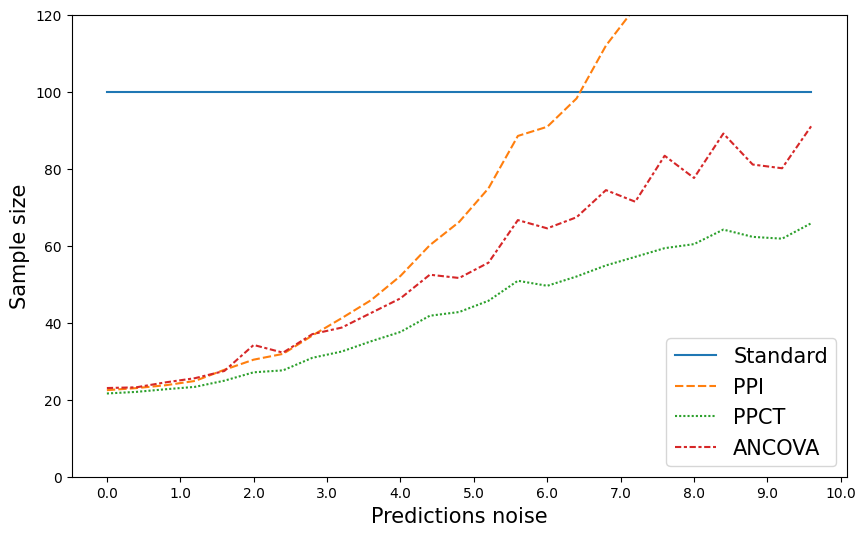

In [108]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 15})
power = estimations.copy()
for col in ['Classical', 'PPI', 'PPI++', 'ANCOVAII']:
    ci = estimations[col]/np.sqrt(variances[col])
    reject = ci < -1.96
    power[col] = reject.values
    nreps = 25000
    power['N'] = [10]*nreps + [100] * nreps + [200]*nreps + [1000]*nreps

mean_power = power.groupby(["N", "Noise_level"]).mean().sort_index().drop(columns=['Repeat_number','R2'])
mean_power.rename(columns={'Classical':'Standard', 'PPI++':'PPCT', 'ANCOVAII':'ANCOVA'}, inplace=True)
sns.lineplot(mean_power.loc[100])
plt.ylim(0.2, 0.8)
plt.xticks(np.arange(0, 11, 1), np.linspace(0, 10, 11).round(2), fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predictions noise")
plt.ylabel("Power")
plt.show()

plt.figure(figsize=(10,6))
mean_var = variances.iloc[nreps:2*nreps].groupby("Noise_level").mean().sort_index().drop(columns=['Repeat_number'])
mean_var.rename(columns={'Classical':'Standard', 'PPI++':'PPCT', 'ANCOVAII':'ANCOVA'}, inplace=True)
sns.lineplot(mean_var / variances.iloc[nreps:2*nreps]["Classical"].mean() * 100)
plt.ylim(0, 120)
plt.xticks(np.arange(0, 11, 1), np.linspace(0, 10, 11).round(2), fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predictions noise")
plt.ylabel("Sample size")
plt.show()

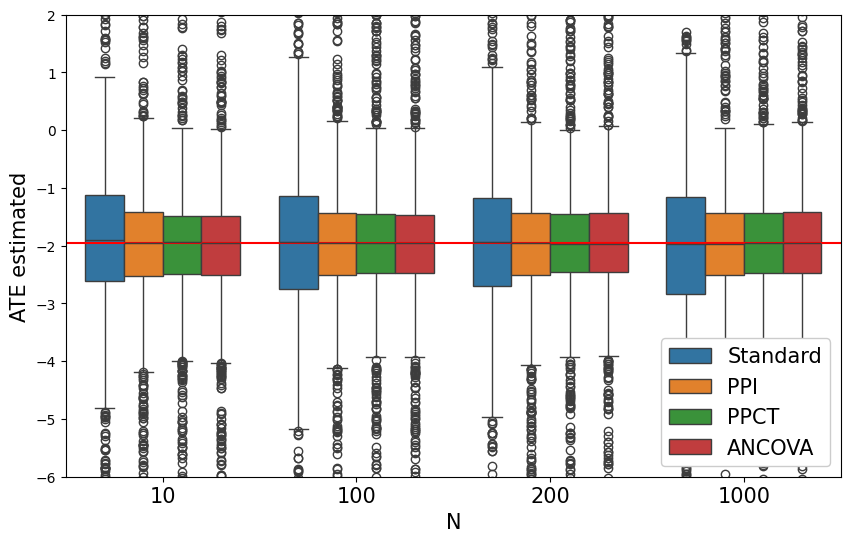

In [122]:
plt.figure(figsize=(10,6))
esti = estimations[estimations["Noise_level"]==4.0].copy()
nreps = 1000
esti['N'] = [10]*nreps + [100] * nreps + [200]*nreps + [1000]*nreps
esti.rename(columns={'Classical':'Standard', 
                     'PPI++':'PPCT', 
                     'ANCOVAII':'ANCOVA'}, 
            inplace=True)
esti.drop(columns=['R2', 'Noise_level', 'Repeat_number'], inplace=True)
def vectorialize(df, col):
    d = df[[col, 'N']].copy()
    d.rename(columns={col:"ATE estimated"}, inplace=True)
    d["Estimator"] = col
    return d
esti = pd.concat([vectorialize(esti, col) for col in ['Standard', 'PPI', 'PPCT', 'ANCOVA']], axis=0)
sns.boxplot(esti, x="N", y="ATE estimated", hue="Estimator")
plt.yticks(fontsize=10)
plt.ylim(-6, 2)
plt.axhline(-1.96, c='red')
plt.legend(loc='lower right', framealpha=1.)
#plt.xlabel("Predictions noise")
#plt.ylabel("Sample size")
plt.show()

## I.2) Exp 2 : Varying endpoint noise

In [3]:
path_exp = '/Users/p-e.poulet/Documents/Aramis/code/notebooks/PPI_CT/simulated_data/Exp2/'
files = os.listdir(path_exp)
files = [file for file in files if file[:4]=='data']
len(files)

1632

In [4]:
estimations = []
variances = []

np.random.seed(42)

for file in files:
    [_, noise, k] = file[:-4].split('_')
    if float(noise):
        data = pd.read_csv(os.path.join(path_exp, file))
        data["Treatment"] = (data["Treatment"]=='Treatment').astype(int)
        data["Model"] = 70. / (1. + np.exp(-data["Eta"] - data["Week"] * data["Alpha"]))
        data["Predictions"] = data["Model"] + np.random.normal(0., 5., size=data.shape[0])
        data.set_index(['Week', 'SubjId'], inplace=True)
        data.sort_index(inplace=True)
        df = data.loc[52].copy()
        df["Adas_change"] = df["Adas"] - data.loc[0]["Adas"]
        df["Predictions_change"] = df["Predictions"] - data.loc[0]["Adas"]
        est, var = estimators.compute_estimators(df, endpoint="Adas_change", treatment="Treatment", prognostic="Predictions_change", covariates=["BMMSE"])
        est["Precision"] = float(noise)
        est["Repeat_number"] = int(k)
        estimations.append(est)
        var["Precision"] = float(noise)
        var["Repeat_number"] = int(k)
        variances.append(var)
estimations = pd.concat(estimations, axis=0)
variances = pd.concat(variances, axis=0)

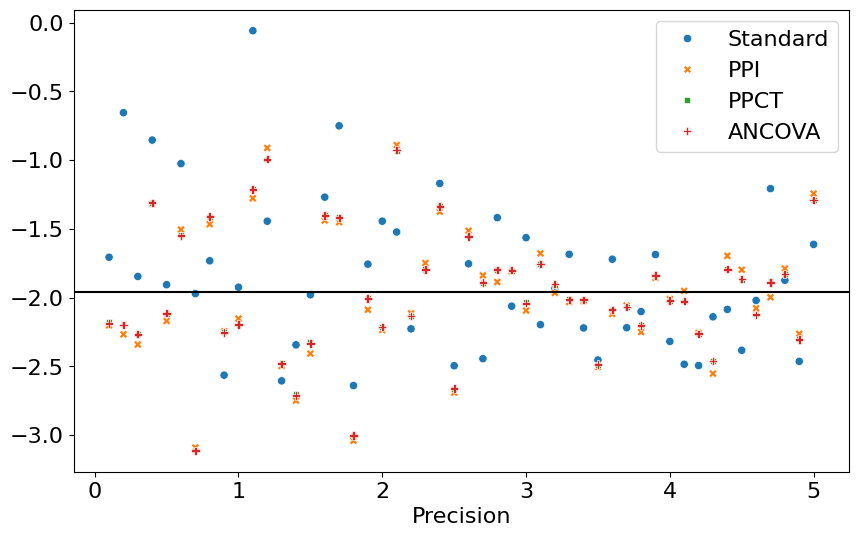

In [6]:
plt.figure(figsize=(10,6))
colors= ['#003f5c', '#7a5195', '#ef5675', 'chocolate']
plt.rcParams.update({'font.size': 16})
mean_est = estimations.groupby("Precision").mean().sort_index().drop(columns=['Repeat_number'])
mean_est.rename(columns={'Classical':'Standard', 'PPI++':'PPCT', 'ANCOVAII':'ANCOVA'}, inplace=True)
sns.scatterplot(mean_est)
#plt.xticks(np.arange(0, 220, 20), np.linspace(0, 2, 11).round(2))
plt.axhline(-1.96, c="black")
plt.show()

# II - Additional experiments

## II.1) Exp 1 : varying treatment effect

In [4]:
path_exp = '/Users/p-e.poulet/Documents/Aramis/code/notebooks/PPI_CT/simulated_data/Exp1/'
files = os.listdir(path_exp)
files = [file for file in files if file[:4]=='data']
len(files)

408

In [5]:
estimations = []
variances = []

np.random.seed(42)

for file in files:
    [_, trt, k] = file[:-4].split('_')
    data = pd.read_csv(os.path.join(path_exp, file))
    data["Treatment"] = (data["Treatment"]=='Treatment').astype(int)
    data["Model"] = 70. / (1. + np.exp(-data["Eta"] - data["Week"] * data["Alpha"]))
    data["Predictions"] = data["Model"] + np.random.normal(0., 2., size=data.shape[0])
    data.set_index(['Week', 'SubjId'], inplace=True)
    data.sort_index(inplace=True)
    df = data.loc[52].copy()
    df["Adas_change"] = df["Adas"] - data.loc[0]["Adas"]
    df["Predictions_change"] = df["Predictions"] - data.loc[0]["Adas"]
    est, var = estimators.compute_estimators(df, endpoint="Adas_change", treatment="Treatment", prognostic="Predictions_change", covariates=["BMMSE"])
    est["Treatment_effect"] = trt
    est["Repeat_number"] = k
    estimations.append(est)
    variances.append(var)
estimations = pd.concat(estimations, axis=0)
variances = pd.concat(variances, axis=0)

/var/folders/zd/m7jdpyld0kl1zgzslfl3xfdr0000gq/T/ipykernel_22543/2194453595.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_est = estimations.groupby("Treatment_effect").mean()


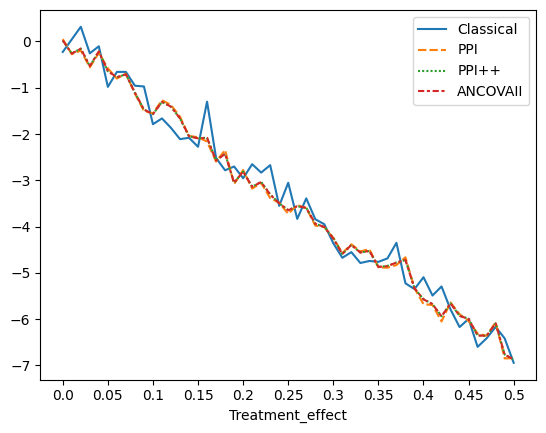

In [6]:
mean_est = estimations.groupby("Treatment_effect").mean()
sns.lineplot(mean_est)
plt.xticks(np.arange(0, 55, 5), np.linspace(0, 0.5, 11).round(2))
plt.show()

In [7]:
# To compare with average endpoint value :
df[df["Treatment"]==0]["Adas_change"].mean()

2.8152801418270066

## 1.3) Exp 3 : Varying model pred performance

In [11]:
path_exp = '/Users/p-e.poulet/Documents/Aramis/code/notebooks/PPI_CT/simulated_data/Exp3/'
files = os.listdir(path_exp)
files = [file for file in files if file[:4]=='data']
len(files)

408

In [12]:
estimations = []
variances = []

np.random.seed(42)

step = 0.2
for file in files:
    [_, noise, k] = file[:-4].split('_')
    noise = float(noise)*step
    data = pd.read_csv(os.path.join(path_exp, file))
    data["Treatment"] = (data["Treatment"]=='Treatment').astype(int)
    data["Model"] = 70. / (1. + np.exp(-data["Eta"] - data["Week"] * data["Alpha"]))
    data["Predictions"] = data["Model"] + np.random.normal(0., noise, size=data.shape[0])
    data.set_index(['Week', 'SubjId'], inplace=True)
    data.sort_index(inplace=True)
    df = data.loc[52].copy()
    df["Adas_change"] = df["Adas"] - data.loc[0]["Adas"]
    df["Predictions_change"] = df["Predictions"] - data.loc[0]["Adas"]
    est, var = estimators.compute_estimators(df, endpoint="Adas_change", treatment="Treatment", prognostic="Predictions_change", covariates=["BMMSE"])
    est["Noise_level"] = noise
    est["R2"] = np.corrcoef(df["Adas_change"], df["Predictions_change"])[0,1]
    est["Repeat_number"] = int(k)
    estimations.append(est)
    var["Noise_level"] = noise
    var["Repeat_number"] = int(k)
    variances.append(var)
estimations = pd.concat(estimations, axis=0)
variances = pd.concat(variances, axis=0)

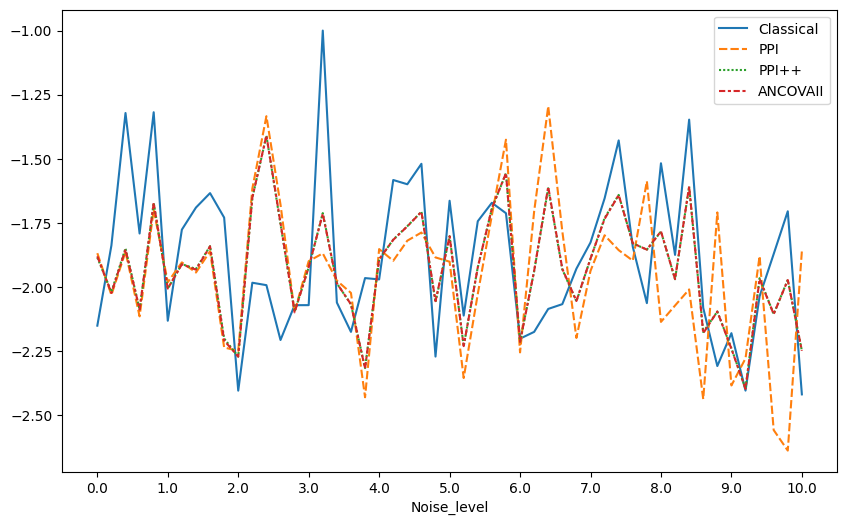

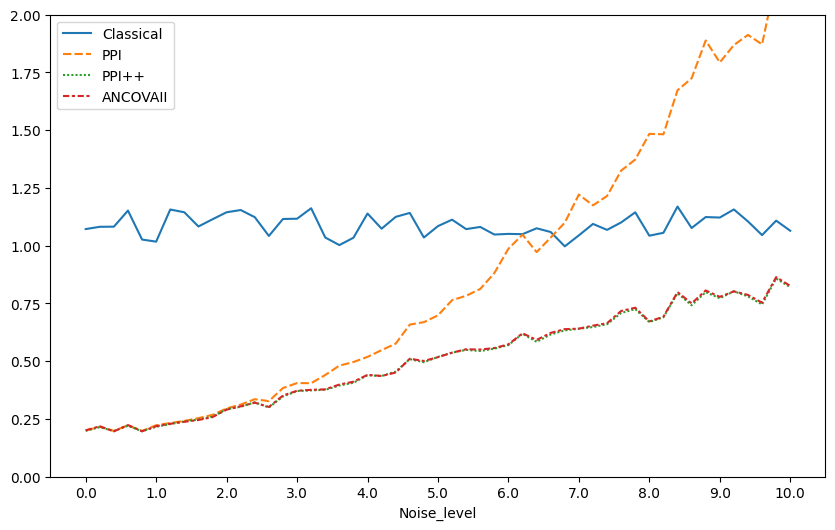

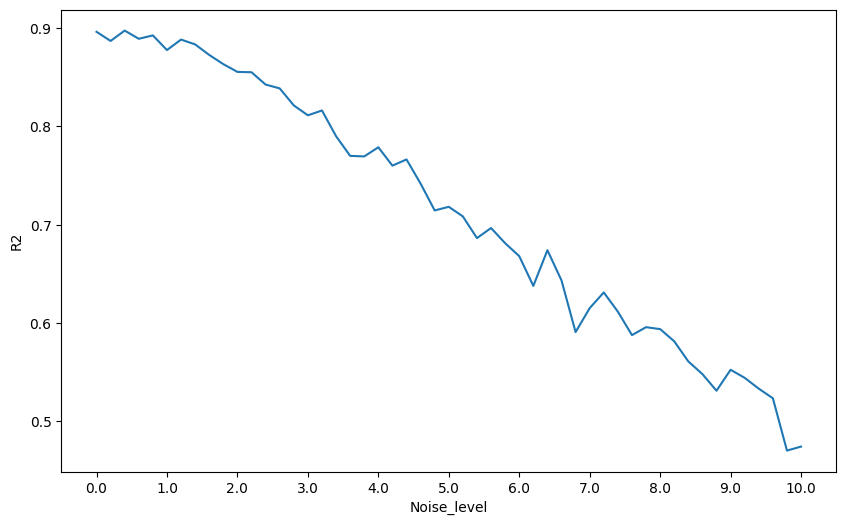

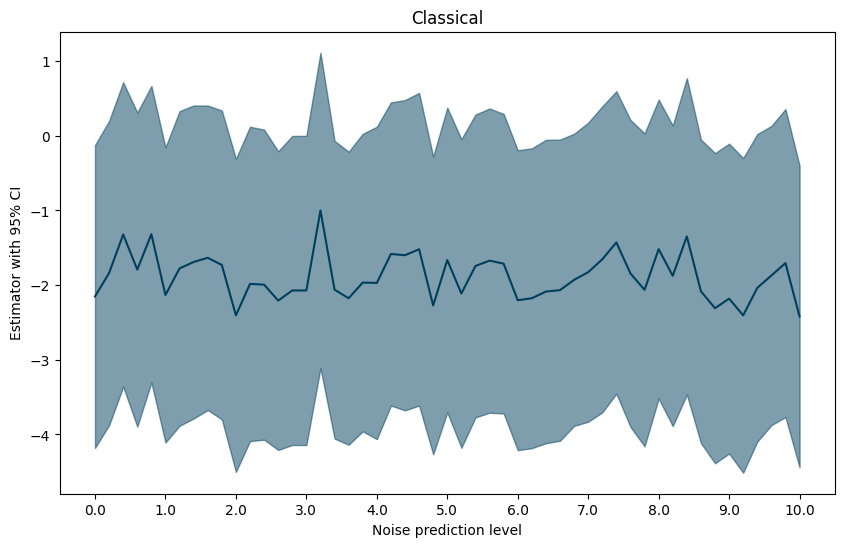

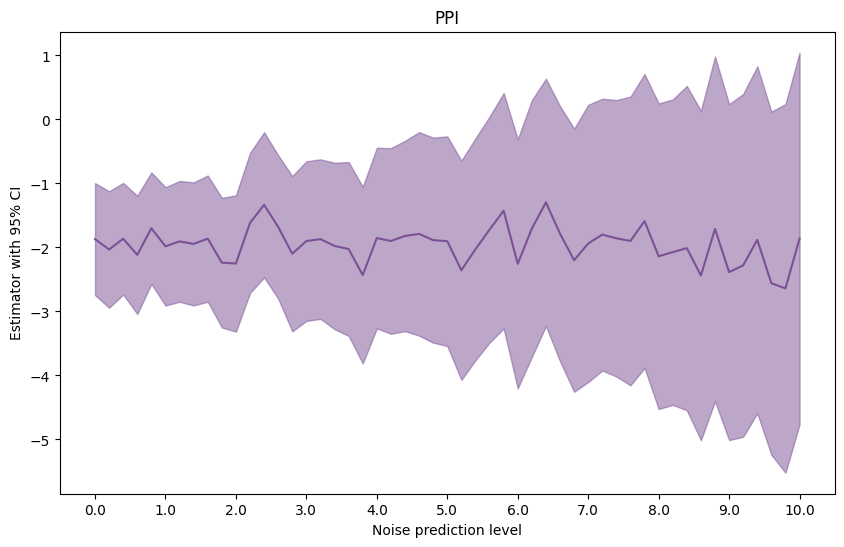

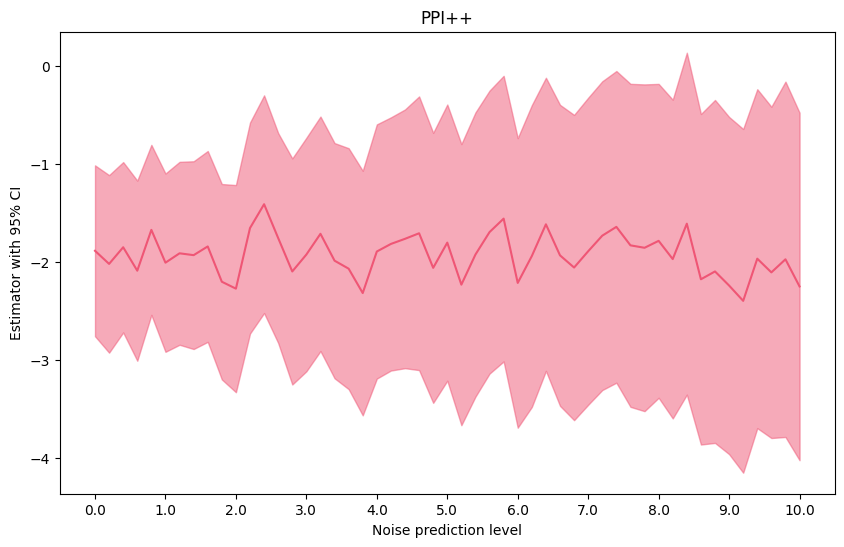

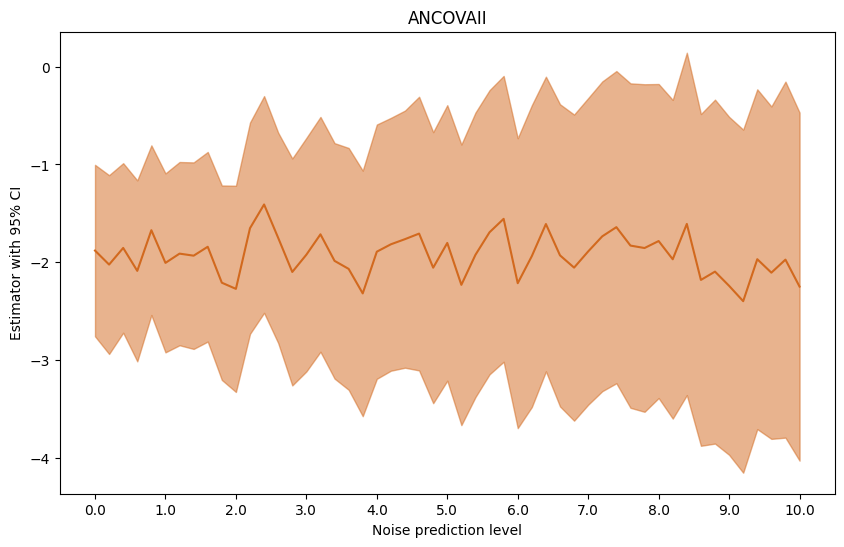

In [13]:
plt.figure(figsize=(10,6))
mean_est = estimations.groupby("Noise_level").mean().sort_index().drop(columns=['Repeat_number', 'R2'])
sns.lineplot(mean_est)
plt.xticks(np.arange(0, 11, 1), np.linspace(0, 10, 11).round(2))
plt.show()

plt.figure(figsize=(10,6))
mean_var = variances.groupby("Noise_level").mean().sort_index().drop(columns=['Repeat_number'])
sns.lineplot(mean_var)
plt.ylim(0, 2)
plt.xticks(np.arange(0, 11, 1), np.linspace(0, 10, 11).round(2))
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(estimations.groupby("Noise_level").mean().sort_index(), x='Noise_level', y='R2')
plt.xticks(np.arange(0, 11, 1), np.linspace(0, 10, 11).round(2))
plt.show()

ab = mean_est.index
a = mean_est.values
ci = 1.96 * np.sqrt(mean_var).values
for k in range(4):
    plt.figure(figsize=(10,6))
    plt.plot(ab, a[...,k], color=colors[k])
    plt.fill_between(ab, a[...,k] - ci[...,k], a[...,k] + ci[...,k], 
                     alpha=0.5, color=colors[k])
    plt.xticks(np.arange(0, 11, 1), np.linspace(0, 10, 11).round(2))
    plt.xlabel("Noise prediction level")
    plt.ylabel("Estimator with 95% CI")
    plt.title(mean_est.columns[k])
    plt.show()

## I.4) Vary model noise with placebo

In [14]:
path_exp = '/Users/p-e.poulet/Documents/Aramis/code/notebooks/PPI_CT/simulated_data/Exp4/'
files = os.listdir(path_exp)
files = [file for file in files if file[:4]=='data']
len(files)

408

In [15]:
estimations = []
variances = []

np.random.seed(42)

step = 0.2
for file in files:
    [_, noise, k] = file[:-4].split('_')
    noise = float(noise)*step
    data = pd.read_csv(os.path.join(path_exp, file))
    data["Treatment"] = (data["Treatment"]=='Treatment').astype(int)
    data["Model"] = 70. / (1. + np.exp(-data["Eta"] - data["Week"] * data["Alpha"]))
    data["Predictions"] = data["Model"] + np.random.normal(0., noise, size=data.shape[0])
    data.set_index(['Week', 'SubjId'], inplace=True)
    data.sort_index(inplace=True)
    df = data.loc[52].copy()
    df["Adas_change"] = df["Adas"] - data.loc[0]["Adas"]
    df["Predictions_change"] = df["Predictions"] - data.loc[0]["Adas"]
    est, var = estimators.compute_estimators(df, endpoint="Adas_change", treatment="Treatment", prognostic="Predictions_change", covariates=["BMMSE"])
    est["Noise_level"] = noise
    est["R2"] = np.corrcoef(df["Adas_change"], df["Predictions_change"])[0,1]
    est["Repeat_number"] = int(k)
    estimations.append(est)
    var["Noise_level"] = noise
    var["Repeat_number"] = int(k)
    variances.append(var)
estimations = pd.concat(estimations, axis=0)
variances = pd.concat(variances, axis=0)

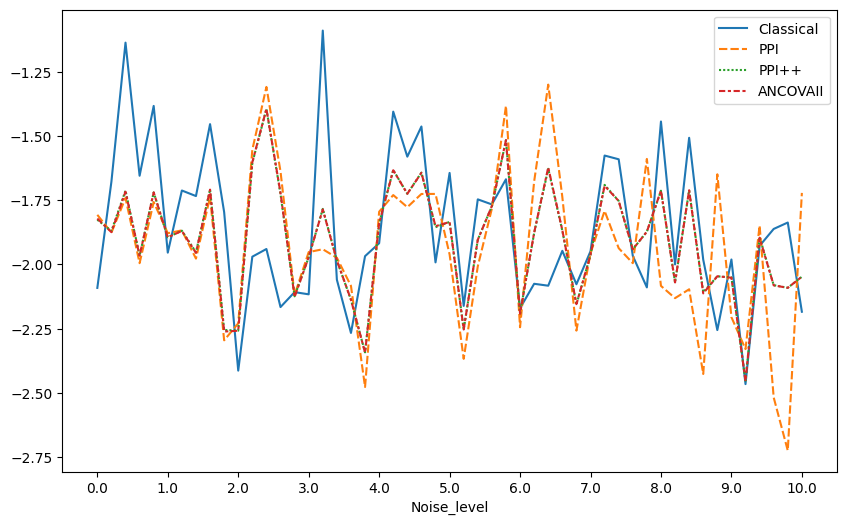

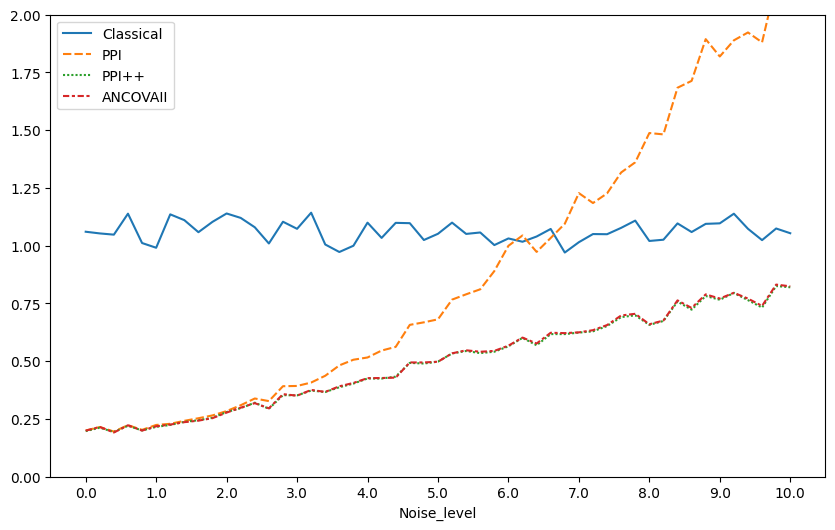

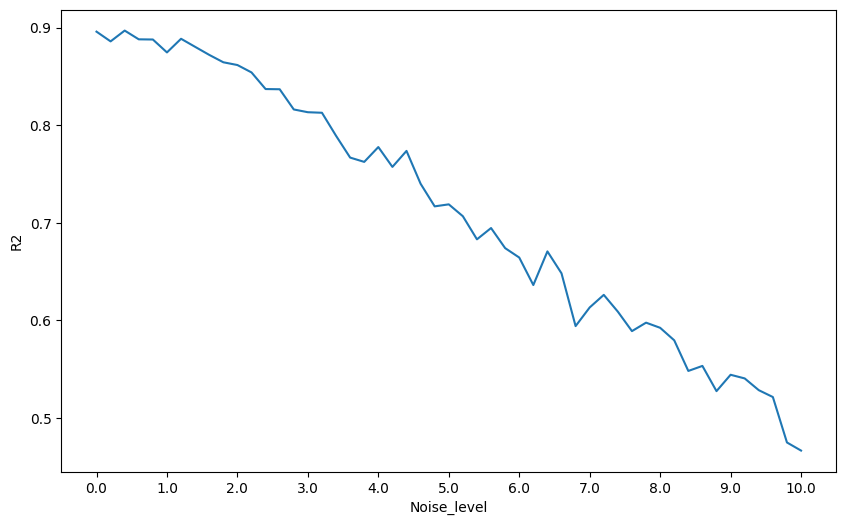

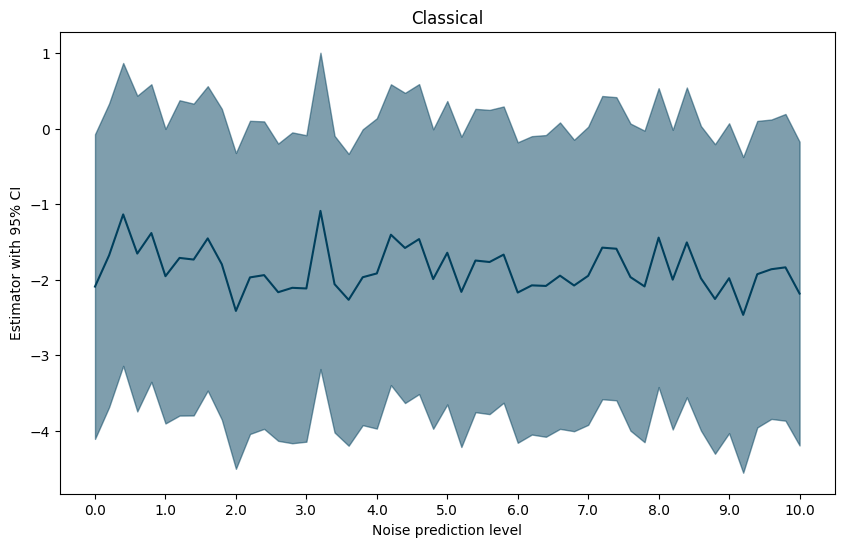

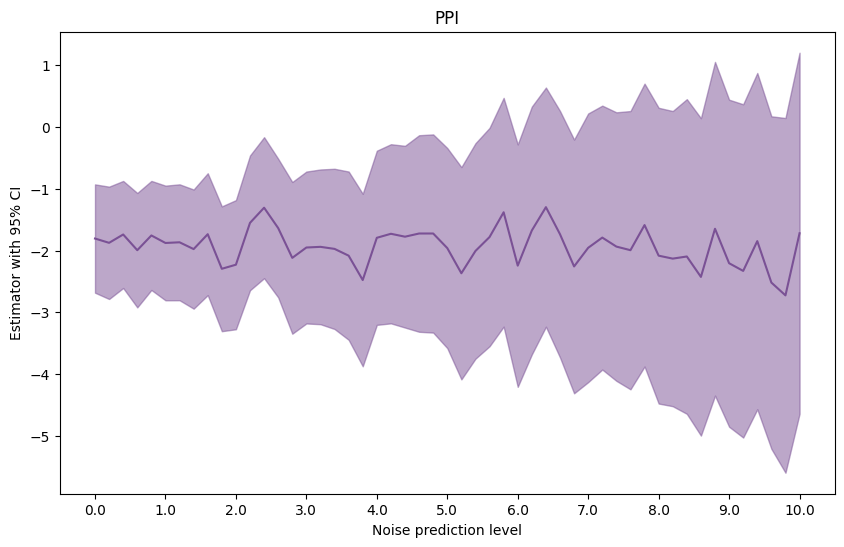

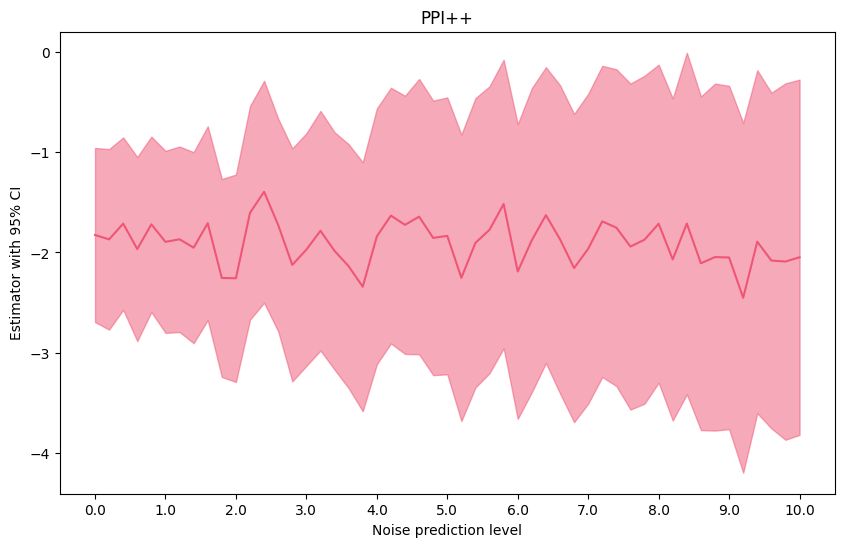

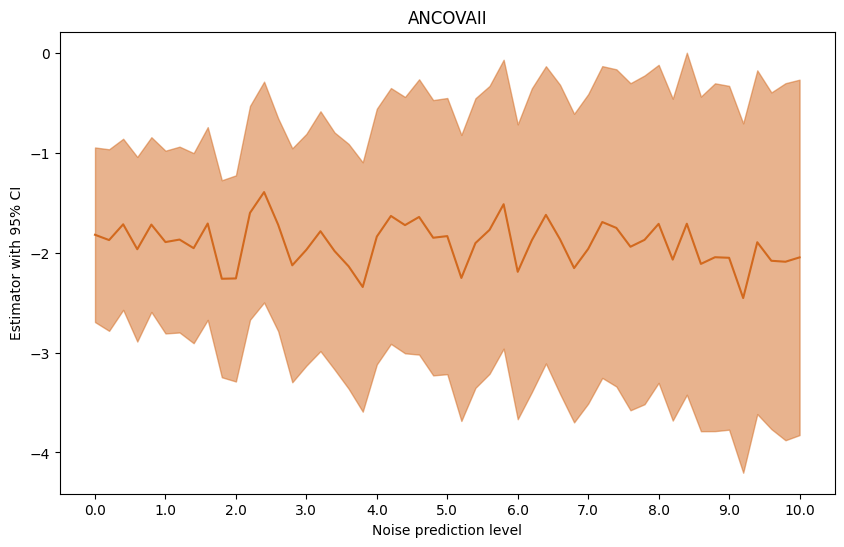

In [16]:
plt.figure(figsize=(10,6))
mean_est = estimations.groupby("Noise_level").mean().sort_index().drop(columns=['Repeat_number', 'R2'])
sns.lineplot(mean_est)
plt.xticks(np.arange(0, 11, 1), np.linspace(0, 10, 11).round(2))
plt.show()

plt.figure(figsize=(10,6))
mean_var = variances.groupby("Noise_level").mean().sort_index().drop(columns=['Repeat_number'])
sns.lineplot(mean_var)
plt.ylim(0, 2)
plt.xticks(np.arange(0, 11, 1), np.linspace(0, 10, 11).round(2))
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(estimations.groupby("Noise_level").mean().sort_index(), x='Noise_level', y='R2')
plt.xticks(np.arange(0, 11, 1), np.linspace(0, 10, 11).round(2))
plt.show()

ab = mean_est.index
a = mean_est.values
ci = 1.96 * np.sqrt(mean_var).values
for k in range(4):
    plt.figure(figsize=(10,6))
    plt.plot(ab, a[...,k], color=colors[k])
    plt.fill_between(ab, a[...,k] - ci[...,k], a[...,k] + ci[...,k], 
                     alpha=0.5, color=colors[k])
    plt.xticks(np.arange(0, 11, 1), np.linspace(0, 10, 11).round(2))
    plt.xlabel("Noise prediction level")
    plt.ylabel("Estimator with 95% CI")
    plt.title(mean_est.columns[k])
    plt.show()